In [1]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation


This is an example of applying :class:`sklearn.decomposition.NMF` and
:class:`sklearn.decomposition.LatentDirichletAllocation` on a corpus
of documents and extract additive models of the topic structure of the
corpus.  The output is a list of topics, each represented as a list of
terms (weights are not shown).

Non-negative Matrix Factorization is applied with two different objective
functions: the Frobenius norm, and the generalized Kullback-Leibler divergence.
The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make
the example runnable in a couple of tens of seconds. You can try to
increase the dimensions of the problem, but be aware that the time
complexity is polynomial in NMF. In LDA, the time complexity is
proportional to (n_samples * iterations).




In [2]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from __future__ import print_function

import itertools
from pathlib import Path
from time import time
import os

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from text_processing.simple import parse_all

n_samples = 20000
n_features = 5000
n_components = 500
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


print("Loading dataset...")
t0 = time()
data_samples = list(itertools.islice(parse_all("./out/docs_simple2"), n_samples))
print("loaded %d samples in %0.3fs." % (len(data_samples), time() - t0))

Loading dataset...
done in 287.694s.


In [3]:
from collections import defaultdict

from nltk.stem.snowball import SnowballStemmer

import numpy as np


class key_dependent_dict(defaultdict):
    def __init__(self, f_of_x):
        super().__init__(None) # base class doesn't get a factory
        self.f_of_x = f_of_x # save f(x)
    def __missing__(self, key): # called when a default needed
        ret = self.f_of_x(key) # calculate default value
        self[key] = ret # and install it in the dict
        return ret


STOP_WORDS = {'от', 'на', 'не', 'рф', 'ст'}

stemmer = SnowballStemmer("russian")
CACHE = key_dependent_dict(lambda w: stemmer.stem(w))


In [4]:
from gensim import corpora, models, similarities

analyzer = TfidfVectorizer().build_analyzer()
texts = [[CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS] for doc in data_samples]
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=10, no_above=0.66)
print(len(dictionary))

13093


In [5]:
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus, smartirs='nnc')
corpus_tfidf = tfidf[corpus]

In [6]:
t0 = time()
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=n_components)
index = similarities.MatrixSimilarity(lsi[corpus_tfidf]) # transform corpus to LSI space and index it
print("LSI index built in %.3fs" % (time()-t0))

LSIindex built in 134.193s


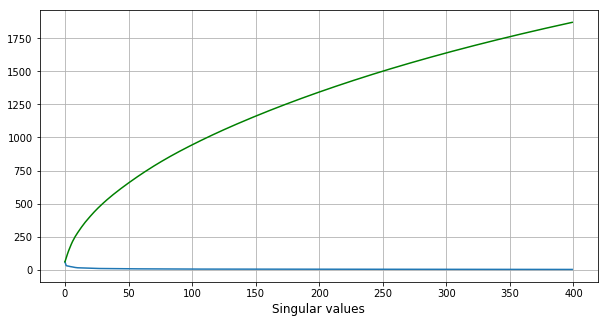

In [7]:
s = lsi.projection.s

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(s[:500])
plt.plot(np.cumsum(s[:500]), c='green')
plt.xlabel('Singular values', fontsize=12)
plt.grid(True, 'both')
plt.show()

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
lsi.print_topics(20,30)

In [8]:
idx = 145
print(data_samples[idx])
doc = corpus_tfidf[idx]
vec_lsi = lsi[doc] # convert the vector to LSI space
sims = index[vec_lsi] # perform a similarity vector against the corpus
most_similar = np.argsort(-sims)[1:]
print()
print(most_similar[2])
print()
print(data_samples[most_similar[2]])

Департамент торговли и услуг города Москвы обратился в Арбитражный суд города Москвы с иском о взыскании с ООО «Западная Торговая Компания» SUM, в том числе: SUM задолженности по внесению платежей за предоставление права размещения торгового объекта за период времени с 01.11.2016г. по 30.04.2017г., SUM пени за общий период с 06.01.2016г. по 30.04.2017г. в связи с нарушением сроков внесения платежей на основании договора на осуществление торговой деятельности (оказания услуг) в нестационарном торговом объекте, находящемся в государственной собственности города Москвы, от 08.06.2016г. № НТО-01-02-NUM, в соответствии со ст.ст. 307, 309, 310, 314 ГК РФ.
Определением от 19.01.2018г. исковое заявление было принято к производству суда с рассмотрением дела в порядке упрощенного производства. В соответствии со ст. 228 АПК РФ судом установлены сроки представления сторонами в суд и друг другу доказательств и документов. 
Стороны о рассмотрении дела в порядке упрощенного производства извещены надл

In [10]:
tf = sorted(corpus_tfidf[idx], key=lambda x:x[1], reverse=True)
print(list(map(lambda t: (dictionary[t[0]], t[1]), tf)))

print()

tf_m = sorted(corpus_tfidf[most_similar[0]], key=lambda x:x[1], reverse=True)
print(list(map(lambda t: (dictionary[t[0]], t[1]), tf_m)))

[('торгов', 0.37151880838356854), ('услуг', 0.24148722544931955), ('юридическ', 0.22291128503014113), ('москв', 0.2043353446109627), ('производств', 0.2043353446109627), ('объект', 0.2043353446109627), ('город', 0.18575940419178427), ('департамент', 0.18575940419178427), ('внесен', 0.16718346377260584), ('08', 0.14860752335342742), ('осуществлен', 0.14860752335342742), ('торговл', 0.130031582934249), ('деятельн', 0.130031582934249), ('оказан', 0.130031582934249), ('плат', 0.130031582934249), ('2017г', 0.130031582934249), ('нестационарн', 0.130031582934249), ('взыска', 0.11145564251507056), ('правил', 0.11145564251507056), ('предпринимател', 0.11145564251507056), ('платеж', 0.11145564251507056), ('2016г', 0.11145564251507056), ('компан', 0.09287970209589214), ('оо', 0.09287970209589214), ('риск', 0.09287970209589214), ('ходатайств', 0.09287970209589214), ('упрощен', 0.09287970209589214), ('западн', 0.09287970209589214), ('быт', 0.07430376167671371), ('времен', 0.07430376167671371), ('до

In [9]:
sorted(sims, reverse=True)

[1.0,
 0.57868683,
 0.56361747,
 0.5206667,
 0.5187095,
 0.5184874,
 0.5172787,
 0.509403,
 0.4987175,
 0.49609083,
 0.49180934,
 0.48925972,
 0.48881674,
 0.4879173,
 0.4844976,
 0.48057535,
 0.48012844,
 0.47420654,
 0.47226334,
 0.47010016,
 0.46898517,
 0.46802118,
 0.46715367,
 0.46422952,
 0.46389067,
 0.46332258,
 0.46309057,
 0.46280402,
 0.4599167,
 0.45980906,
 0.45965216,
 0.45879567,
 0.45866063,
 0.45846504,
 0.4573412,
 0.45713228,
 0.45516765,
 0.4551636,
 0.45474648,
 0.45452678,
 0.4538681,
 0.4538433,
 0.45363608,
 0.44945404,
 0.44889674,
 0.44839206,
 0.44774783,
 0.4475665,
 0.4468292,
 0.44660985,
 0.44650453,
 0.4463825,
 0.4455452,
 0.44494918,
 0.4446024,
 0.44428062,
 0.4430248,
 0.4426486,
 0.4422757,
 0.44216165,
 0.44143388,
 0.44136727,
 0.44135174,
 0.44107628,
 0.44014236,
 0.43991405,
 0.43834403,
 0.43784404,
 0.4375632,
 0.43749255,
 0.43738747,
 0.4370902,
 0.43658006,
 0.4354282,
 0.4351431,
 0.4348387,
 0.43359414,
 0.43297946,
 0.43266582,
 0.4325

In [ ]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS])


class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([CACHE[w] for w in analyzer(doc) if w not in STOP_WORDS])


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = StemmedTfidfVectorizer(max_df=0.9, min_df=2,
                                   max_features=n_features,
                                   stop_words=None)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = StemmedCountVectorizer(max_df=0.9, min_df=2,
                                max_features=n_features,
                                stop_words=None)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)